# Kostrov summation
## From moment sensors to deformation, strain rate and velocity

In [42]:
from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from shapely.geometry import shape
from shapely.ops import transform
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely as sp
import pyproj

with open('caribbean7decmw0.txt') as f:
    array = [[x for x in line.split()] for line in f]
cmt_data = np.array(array)

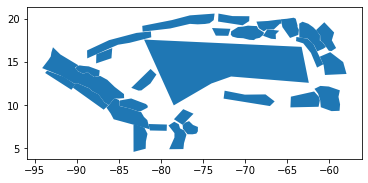

In [43]:
# specify the polygons
import geopandas as gpd
import matplotlib.pyplot as plt

# enabling reading kml files with geopandas
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

fp = "final_polygons.kml"
polys = gpd.read_file(fp, driver='KML')
polygons = polys[['geometry']]

polygons.plot()
import pandas as pd
import shapely as sp
def coord_lister(geom):
    coords = list(geom.exterior.coords)
    return (coords)

coordinates = polygons.geometry.apply(coord_lister)

## Seismic moment - magnitude relationship

[1.492618 16.091039]


Text(0.5, 1.0, 'Seismic moment - magnitude relationship for the Caribbean plate')

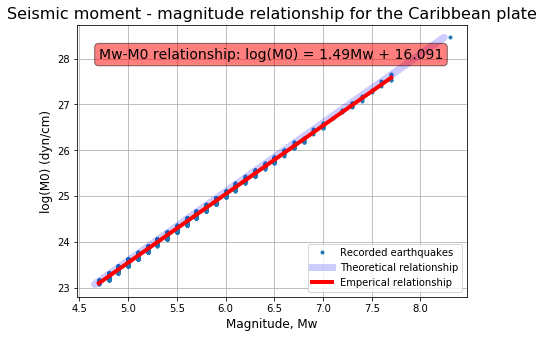

In [44]:
#http://geophysics.geo.auth.gr/new_web_site_2007/download_files/costas_CV/23.pdf
plot_m0 = []
plot_mw = []

for i in range(len(cmt_data)):
    log_m0 = (np.log10(float(cmt_data[i][14])))
    plot_m0.append(log_m0)
    plot_mw.append(float(cmt_data[i][13]))
    
poly_coeffs_m = np.polyfit(plot_mw, plot_m0, 1)
print(poly_coeffs_m)
x_m = np.linspace(4.7, 7.7, 100)
pm = np.poly1d(poly_coeffs_m)
box = dict(boxstyle='round', facecolor='red', alpha=0.5)

original_relationship = []
for i in plot_m0:
    mw = i/(1.5) -10.73
    original_relationship.append(mw)
    
    
fig = plt.figure(figsize=(7,5))
plt.plot(plot_mw, plot_m0, '.', label = 'Recorded earthquakes')

plt.plot(original_relationship, plot_m0,'blue', linewidth=7.0,alpha = 0.2,label= 'Theoretical relationship')
plt.plot(x_m, pm(x_m), 'red', linewidth=4.0,label= 'Emperical relationship')
plt.text(4.7, 28, 'Mw-M0 relationship: log(M0) = 1.49Mw + 16.091', fontsize = 14, bbox=box)
plt.xlabel('Magnitude, Mw', fontsize = 12)
plt.ylabel('log(M0) (dyn/cm)', fontsize = 12)
plt.grid()
plt.legend(loc= 'lower right')
plt.title('Seismic moment - magnitude relationship for the Caribbean plate', size = 16)

In [45]:
import warnings
warnings.filterwarnings("ignore") # filter warnings for changing coordinate systems

def kostrov_summation(eq_zone):
    # kostrov summation
    mrr = 0
    mtt = 0
    mpp = 0
    mrt = 0
    mrp = 0
    mtp = 0
    scalar_moment = 0

    # sum up all tensors
    for i in range(len(eq_zone)):
        iexp = int(eq_zone[i][9])
        mrr += float(eq_zone[i][3])*10**iexp
        mtt += float(eq_zone[i][4])*10**iexp
        mpp += float(eq_zone[i][5])*10**iexp
        mrt += float(eq_zone[i][6])*10**iexp
        mrp += float(eq_zone[i][7])*10**iexp
        mtp += float(eq_zone[i][8])*10**iexp
        
        scalar_moment += float(eq_zone[i][14])
        
    # convert from dyn cm to Nm   
    mrr = mrr/10**7
    mtt = mtt/10**7
    mpp = mpp/10**7
    mrt = mrt/10**7
    mrp = mrp/10**7
    mtp = mtp/10**7
    
     # convert to float notation 
    mrr = mrr/10**16
    mtt = mtt/10**16
    mpp = mpp/10**16
    mrt = mrt/10**16
    mrp = mrp/10**16
    mtp = mtp/10**16
    
    return mrr, mtt, mpp, mrt, mrp, mtp


# store tensors
tensors = []
coords = []
frequency = []
scalar_moments = []
box_depth = []
max_box_depth = []
areas = []

# depth constraints on boxes
box_depth1 = (-91.80953949802839, 12.906861060724344)
box_depth2 = (-89.35831739963655, 13.181528333815479)
box_depth3 = (-88.64458334948695, 13.991108344948625)
box_depth4 = (-83.30358287371013, 10.030047742119372)
# atlantic side
box_depth5 = (-62.85911931879894, 10.523324857999352) # 60 km diep cutoff
box_depth6 = (-59.607810857910515, 14.652518442915289)
box_depth7 = (-60.0604751774371, 10.802684775900197)
box_depth8 = (-60.34008699007553, 17.9366145567412)
              
#box_depth1 = ((0,0))
#box_depth2 = ((0,0))
#box_depth3 = ((0,0))
#box_depth4 = ((0,0))
# atlantic side
#box_depth5 = ((0,0)) # 60 km diep cutoff
#box_depth6 = ((0,0))
#box_depth7 = ((0,0))
#box_depth8 = (0,0)

for i in coordinates:
    poly = Polygon(i)
    coord_poly = list(poly.centroid.coords)
    
    # keep track of number of earthquakes within polygon
    eq_zone = []
    eq_zone_depth = []
    freq_eqs = []
    scalar_moment1 = 0
    scalar_moment2 = 0
    number_eqs1 = 0
    eq_depths1 = 0
    max_depth1 = []
    number_eqs2 = 0
    eq_depths2 = 0
    max_depth2 = []
    for line in range(len(cmt_data)):
        x = (float(cmt_data[line][0]))
        y = (float(cmt_data[line][1]))
        point = Point(x,y)
        
        # add earthquakes to catalogue if it is within the polygon
        if (poly.contains(point)) == True:
            depth = (float(cmt_data[line][2]))
            # if we're in the right polygon, we will distinguish eqs between depths
            # depth constraints on boxes to do the summation twice. 
            # box 1 is divided in depth for 40 km
            # mexico side
            if coord_poly[0] == box_depth1 or coord_poly[0] == box_depth2 or coord_poly[0] == box_depth3 or coord_poly[0] == box_depth4:
                if depth < 40:
                    eq_zone.append(cmt_data[line])
                    eq_depths1 += depth
                    max_depth1.append(depth)
                    number_eqs1 += 1
                    scalar_moment1 += float(cmt_data[line][14])
                else: 
                    eq_zone_depth.append(cmt_data[line])
                    eq_depths2 += depth
                    max_depth2.append(depth)
                    number_eqs2 += 1 
                    scalar_moment2 += float(cmt_data[line][14])
            # Atlanctic side        
            elif coord_poly[0] == box_depth5 or coord_poly[0] == box_depth6 or coord_poly[0] == box_depth7 or coord_poly[0] == box_depth8:
                if depth < 40:
                    eq_zone.append(cmt_data[line])
                    eq_depths1 += depth
                    max_depth1.append(depth)
                    number_eqs1 += 1
                    scalar_moment1 += float(cmt_data[line][14])
                else: 
                    eq_zone_depth.append(cmt_data[line])
                    eq_depths2 += depth
                    max_depth2.append(depth)
                    number_eqs2 += 1 
                    scalar_moment2 += float(cmt_data[line][14])
            # if the box is not divided by depth, all earthquakes are included         
            else: 
                eq_zone.append(cmt_data[line])
                eq_depths1 += depth
                max_depth1.append(depth)
                number_eqs1 += 1
                scalar_moment1 += float(cmt_data[line][14])
            
            # collect data for frequency magnitude plot
            freq_eqs.append(float(cmt_data[line][13]))
            
    if number_eqs1 == 0:
        mean_depth1 = 0
    else: 
        mean_depth1 = eq_depths1 / number_eqs1
        max_depths1 = max(max_depth1)
        max_box_depth.append(max_depths1 * 1000) #from kilometres to m
    box_depth.append(max_depths1*1000) #from kilometres to m
    scalar_moments.append(scalar_moment1)
    mrr,mtt,mpp,mrt,mrp,mtp = kostrov_summation(eq_zone)

    tensors.append([*coord_poly[0],mean_depth1,mrr,mtt,mpp,
                    mrt,mrp,mtp,16,'X', 'Y', '200808180916A'])
    
    # Calculate the areas of the polygon  
    s = shape(poly)
    # from spherical to cartesian coordinates
    proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),
               pyproj.Proj(init='epsg:3857'))
    s_new = transform(proj, s)
    poly_area = transform(proj, s).area
    areas.append(poly_area)
    
    # if eq_zone_depth exists, we will do kostrov summation on bottom of box as well
    if len(eq_zone_depth) != 0:
        mean_depth2 = eq_depths2 / number_eqs2
        # 40 km is the upper depth of the box
        max_depths2 = max(max_depth2)
        max_box_depth.append((max_depths2-40)*1000) # to m
        # two boxes for depths so area twice in the list
        areas.append(poly_area)
        box_depth.append(mean_depth2*1000) #from kilometres t
        scalar_moments.append(scalar_moment2)
        dmrr, dmtt, dmpp, dmrt, dmrp, dmtp = kostrov_summation(eq_zone_depth)    
        
        # want new coordinates for deep boxes in order to recognise them on the GMT map
        coord_depth = np.subtract(coord_poly[0], (0.5, 0.5))
        tensors.append([*coord_depth,mean_depth2,dmrr,dmtt,dmpp,
                    dmrt,dmrp,dmtp,16,'X', 'Y', '200808180916D'])
    
    frequency.append([*coord_depth,*freq_eqs])
    

In [46]:
coord_depth = np.subtract(coord_poly[0], (0.5, 0.5))

In [47]:
tensor = np.array(tensors)
#tensor = tensor.astype(np.float)
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

np.savetxt('polygonsdepth.txt', tensor, delimiter = ' ', fmt="%s")

------------------------------------------------------------------------------------

# USE MTTK IN LINUX!

In [48]:
df = pd.read_excel (r'boxinfo.xlsx', columns= ['coordinates', 'eigenvalues'])
values = df.to_numpy()

## Calculate strain and velocity
you are assigning a single velocity/strain rate solution to each box

In [49]:
# calculate strain tensor ON DIAGONALISED MATRIX!!!!! NOT THIS ONE
# strain = 1/(2*mu*V) * sum of moment tensors
# mu is 3.3*10ˆ10 according to (Stacey)
# divide by t too, time in seconds from start, to get de/dt

volumes = []
# calculate volume of all the boxes
for i in range(len(areas)):
    volume_box = float(areas[i]) * float(max_box_depth[i]) # max depth or seismogenic depth
    volumes.append(volume_box)

mu = 3.3*10**10
strain_tensors = []

i = 0

for i in range(1, len(values)):
    e_t = float(values[i][2])/(mu*volumes[i-1]*2)*10**16*10**7
    print(values[i][2])
    print(volumes[i-1])
    print(e_t/t)
    e_b = float(values[i][3])/(mu*volumes[i-1]*2)*10**16*10**7
    e_p = float(values[i][4])/(mu*volumes[i-1]*2)*10**16*10**7
    lon = float(tensors[i-1][0])
    lat = float(tensors[i-1][1])
    strain_tensors.append([lon, lat, e_t, e_b, e_p])
    i += 1    

# compute strain rate
strain_rates = []
t = (2021-1976 + 10/12) * 365.25 * 24 * 3600
for line in strain_tensors:
    et_t = float(line[2])/t
    et_b = float(line[3])/t
    et_p = float(line[4])/t
    strain_rates.append([float(line[0]), float(line[1]), et_t, et_b, et_p])

# string crosses from diagonalised summed moment tensors MTTK, gmt velo]

39715.5440
3533233023666643.0
1.1774945036926483e-08
80.3806
470548886979614.44
1.7894400248600206e-10
12489.0299
2199928937978238.0
5.946900973660812e-09
309.2057
815918385809403.4
3.969825577845916e-10
47120.0655
3430534223010625.0
1.4388475551755651e-08
289.1211
2.5120879124194624e+16
1.2056343350579982e-11
666.9529
2294378417564453.5
3.0450944689910435e-10
3933.4442
383262291776466.75
1.075096765737339e-08
789.3212
2054520410525419.0
4.024518807597249e-10
11754.0384
7378403716558133.0
1.6687656235633462e-09
1354.9258
2594119679820426.5
5.471370922536776e-10
67.7612
1752783567446234.2
4.049705569464943e-11
3482.2625
2054667801002658.5
1.7753768182914953e-09
10592.3202
7705004253759969.0
1.440087470717729e-09
1028.4641
3139092894375839.5
3.4320659350919293e-10
1320.7459
9336789121733266.0
1.4818095010081384e-10
173.2968
422000390788346.6
4.301781466456355e-10
10954.7732
1794797947821996.2
6.393791652664691e-09
482.1810
1627492476781496.0
3.103571517541728e-10
5676.9134
82171586559038

## compute strain crosses by making file
After using a bit of trigonometry to determine the horizontal components of the tensor

In [39]:
## make file to plot strain crosses
strain_crossesred = []
strain_crossesblue = []
strain_crosses = []
strain_b = []
t = (2021-1976 + 10/12) * 365.25 * 24 * 3600
for i in range(len(strain_rates)):
    empty = float(values[i+1][6])
    if np.isnan(empty) != True:
        lon_strain = strain_rates[i][0]
        lat_strain = strain_rates[i][1]
        I_strain = float(strain_rates[i][3])
        I_dip = np.deg2rad(float(values[i+1][9]))
        I_hor_strain = I_strain * np.cos(float(I_dip))
        T_strain = float(strain_rates[i][2])
        T_dip = np.deg2rad(float(values[i+1][11]))
        T_hor_strain = T_strain * np.cos(float(T_dip))
        P_strain = float(strain_rates[i][4])
        # horizontal strain = strain * P dip
        P_dip = np.deg2rad(float(values[i+1][7]))
        P_hor_strain = P_strain * np.cos(float(P_dip))
        P_strike = float(values[i+1][8])
        strain_crosses.append([lon_strain,lat_strain,T_hor_strain,P_hor_strain,P_strike])
        strain_crossesred.append([lon_strain,lat_strain,T_hor_strain,0,P_strike])
        strain_crossesblue.append([lon_strain,lat_strain,0,P_hor_strain,P_strike])
        
        print(T_hor_strain)
        print(P_hor_strain)
        strain_b.append([T_hor_strain,I_hor_strain,P_hor_strain])
        
strain_crossred = np.array(strain_crossesred)
strain_crossblue = np.array(strain_crossesblue)
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

np.savetxt('strain_crossesredf.txt', strain_crossred, delimiter = ' ', fmt="%s")
np.savetxt('strain_crossesbluef.txt', strain_crossblue, delimiter = ' ', fmt="%s")

NameError: name 'strain_rates' is not defined

## Velocity

In [40]:
# for velocity, use sum of all the moment tensors. 
# but use with and length of fault too
# velocity = 1/(mu*L*W*t)* sum(m_0)

# Length of faults in boxes from a csv file
velocities = []
t = (2021-1976 + 10/12) *365.25*24*3600
mu =  3.3*10**10 
for i in range(len(m0_data)):
    m0 = float(m0_data[i][13])
    L = float(values[i+1][6]) #in m
    if np.isnan(L) != True:
        #max_depth = box_depth[i]
       # W = max_depth *  # example
        w = max_box_depth[i] * 1000
        dip_fault = float(values[i+1][19])
        dip_rad = np.deg2rad(dip_fault)
        W = w*np.cos(float(dip_rad))
        v = 1/(L*mu*W*t)*m0
        if v < 0:
            v = v * -1
        # convert to mm/yr
        vyr = v * 3.1556926 * 10 ** 10 
        velocities.append([float(m0_data[i][0]),float(m0_data[i][1]), vyr])
    else: velocities.append([float(m0_data[i][0]),float(m0_data[i][1]), 'nan'])

IndexError: index 37 is out of bounds for axis 0 with size 37

In [437]:
with open('veloc.txt') as file:
    array1 =[[x for x in line.split()] for line in file]
gpsvelo = np.array(array1)

In [438]:
# calculate velocities
absolutes = []
for line in gpsvelo:
    e = float(line[2])
    n = float(line[3])
    absolute = np.sqrt(e **2 + n**2)
    absolutes.append([float(line[0]), float(line[1]), absolute])

In [439]:
# analyse velocities and strain rates
len(velocities)
velo = []
for i in velocities:
    if np.isnan(float(i[2])) != True:
        velo.append(i)

compare = []
for i in range(len(velo)):
    b = velo[i]
    c = strain_crosses[i]
    d = c[2:]
    compare.append([*b, *d])
    
strain_and_velo = np.array(compare)
#tensor = tensor.astype(np.float)
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

np.savetxt('strain_and_velo1.csv', strain_and_velo, delimiter = ' ', fmt="%s")

## Seismic coupling

In [440]:
# coupling = velocity/gps velocity
coupling = []
coup =[]
for i in range(1, len(values)):
    velocity = float(velocities[i-1][2])
    gps_velocity = float(values[i][5])
    if np.isnan(gps_velocity) != True:
        lon = float(velocities[i-1][0])
        lat = float(velocities[i-1][1])
        seismic_coupling = velocity / gps_velocity
        coupling.append([lon, lat, seismic_coupling])
        coup.append(seismic_coupling)

[['-85.09052600777473' '17.227151647225426' '20.25' '-2627.95'
  '-19832.320000000003' '22460.97' '-3031.6800000000007'
  '7037.770000000002' '31396.070000000003' '16' 'X' 'Y' '200808180916A'
  '4.0E+20']
 ['-86.759227093664' '15.691218641096363' '14.454545454545455' '-83.16'
  '18.49' '64.78' '13.6' '19.319999999999997' '26.839999999999996' '16'
  'X' 'Y' '200808180916A' '8.0E+17']
 ['-82.55561451789657' '6.16605363315168' '19.095808383233532'
  '-582.8500000000001' '755.4800000000001' '-186.07999999999996'
  '1771.41' '1735.6599999999983' '11724.42' '16' 'X' 'Y' '200808180916A'
  '1.2E+20']
 ['-81.92155006231083' '12.797393501136108' '14.235294117647058'
  '-68.81999999999998' '-127.26' '196.19999999999996'
  '-13.379999999999997' '10.090000000000002' '222.06' '16' 'X' 'Y'
  '200808180916A' '3.1E+18']
 ['-77.67016478244659' '19.577097310133993' '16.77777777777778'
  '-1240.88' '-19595.619999999995' '20836.58' '5109.19'
  '-2816.2499999999995' '41872.52999999999' '16' 'X' 'Y' '2008081

In [441]:
# M_seis = c * M_tectonic https://academic.oup.com/gji/article/209/1/32/2893453
 #high c, many earthquakes
    # low c: aseismic deformation


Text(0.5, 1, 'Heatmap of the deformation type for regions in the caribbean plate')

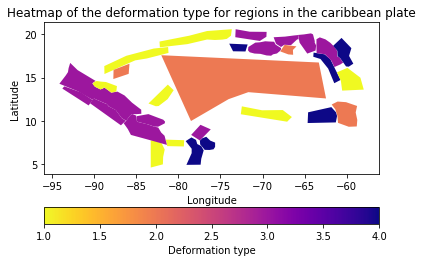

In [442]:
poly_deftype = gpd.GeoDataFrame.copy(polygons)
poly_deftype['def_type'] = def_types

fig, ax = plt.subplots(1, 1)
poly_deftype.plot(column='def_type', cmap='plasma_r', ax=ax, legend= True, legend_kwds={'label': "Deformation type",
                        'orientation': "horizontal"})
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Heatmap of the deformation type for regions in the caribbean plate')

In [34]:
# style of deformation from my strain rates
len(strain_rates)

# calculate style tensor
def defstyle(emax, emin):
    return (emax+emin)/max(abs(emax), abs(emin))

strain_rates_boxes = []
for i in range(len(strain_rates)):
    def_type = float(values[i+1][24])
    if np.isnan(def_type) != True:
        strain_rates_boxes.append(strain_rates[i])

defstyles = []       
for j in strain_rates_boxes:
    emax = j[2]
    emin = j[4]
    defs = defstyle(emax,emin)
    defstyles.append(defs)

    # -1 is contraction, +1 is extension, 0 is strike-slip
poly_deftype = gpd.GeoDataFrame.copy(polygons)
poly_deftype['def_type'] = defstyles

fig, ax = plt.subplots(1, 1)
poly_deftype.plot(column='def_type', cmap='bwr', ax=ax, legend= True, legend_kwds={'label': "Contraction               Strike-slip                Extension",
                        'orientation': "horizontal"})
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Heatmap of the deformation type for regions in the caribbean plate')

NameError: name 'strain_rates' is not defined

Text(0.5, 1, 'Heatmap of the seismic coupling at the caribbean plate')

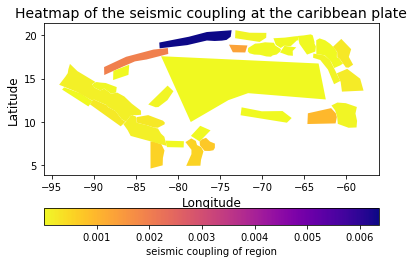

In [444]:
vandgps = gpd.GeoDataFrame.copy(polygons)

for i in range(len(coup)):
    if coup[i] > 2:
        coup[i] = 2

vandgps ['seismic_c'] = coup

fig, ax = plt.subplots(1, 1)
vandgps.plot(column='seismic_c', cmap='plasma_r', ax=ax, legend= True, legend_kwds={'label': "seismic coupling of region",
                        'orientation': "horizontal"})
plt.xlabel('Longitude', fontsize = 12)
plt.ylabel('Latitude', fontsize = 12)
plt.title('Heatmap of the seismic coupling at the caribbean plate', fontsize = 14)

Text(0, 0.5, 'b-value')

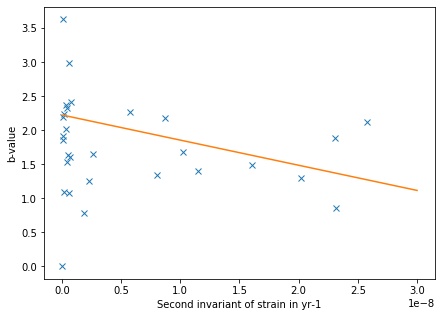

In [446]:
## Correlation strain and b -value
# CALCULATE SECOND INVARIANT
absolute_strain = []
for i in range(len(strain_b)):
    #e = np.sqrt(float(strain_b[i][0])**2+float(strain_b[i][1])**2+float(strain_b[i][2])**2)
    e = np.sqrt(float(strain_b[i][0])**2+float(strain_b[i][2])**2)
    absolute_strain.append(e)

final_b = []
final_strain = []

for i in range(len(bs)):
    if np.isnan(bs[i]) != True:
        final_b.append(bs[i])
        final_strain.append(absolute_strain[i])
    
poly_coeffs = np.polyfit(final_strain, final_b, 1)
x_line = np.linspace(0.4*10**-10, 0.3*10**-7, 100)
p1 = np.poly1d(poly_coeffs) 
    
fig = plt.figure(figsize=(7,5))

plt.plot(absolute_strain, b_plot, 'x')
plt.plot(x_line, p1(x_line))
plt.xlabel('Second invariant of strain in yr-1')
plt.ylabel('b-value')